## Classification and Regression Trees

- CART model did better than law experts in predicting whether the upper house will pass bills from the lower house
- Q: Is it possible to predict whether the upper house will affirm or reverse the lower house's decisions
- An intuitive idea will be to use a long list of predictor variables, such as:
    - Circuit of origin
    - Issue area of case
    - Petition type
    - Respondent type
    - Ideological direction of lower house


- How regression trees work:
    - cut such that y-values are as homogeneous as possible within the same convex hull (as small of a variance as possible)
    - similar to BSP trees??


- Model prediction function:
    - $f(x) = \sum_{x=1}^{m}\bar{y}_m1_{x\in R_m}$
    

- How do we decide on the number of splits:
    - implement a stopping threshold such that each subregion should have at least 5 observations


- How do we decide on the position of the split:
    - *greedy approach*: find split across each variable (dimension) such that it minimises least-square error for each split
    - *SVM*: ???

In [80]:
# reading the data
supreme <- read.csv("csv/supreme.csv")
head(supreme)

str(supreme)

docket,term,party_1,party_2,rehndir,stevdir,ocondir,scaldir,kendir,soutdir,thomdir,gindir,brydir,petit,respon,circuit,unconst,lctdir,issue,result
92-2038,1994,FOOD,FARMER,1,0,1,1,1,1,1,1,1,BUSINESS,BUSINESS,FED,0,liberal,ECN,1
93-1001,1994,FRANCHIS,O,0,0,0,1,0,0,1,0,0,OTHER,OTHER,11th,0,conser,ECN,0
93-1128,1994,VTAD,VETERAN,0,0,0,0,0,0,0,0,0,OTHER,OTHER,FED,0,liberal,CR,0
93-1151,1994,FEC,PAC,1,0,1,1,1,1,1,9,1,OTHER,OTHER,DC,0,conser,JUD,1
93-1170,1994,US,UNION,1,0,0,1,0,0,1,0,0,US,OTHER,DC,0,liberal,FA,0
93-1197,1994,IC GOEE,IC,1,0,1,1,0,0,1,0,0,EE,OTHER,3rd,0,conser,ECN,0


'data.frame':	623 obs. of  20 variables:
 $ docket : Factor w/ 623 levels "","00-1011","00-1021",..: 100 101 102 103 104 105 106 107 108 109 ...
 $ term   : int  1994 1994 1994 1994 1994 1994 1994 1994 1994 1994 ...
 $ party_1: Factor w/ 216 levels "0","AC","AG",..: 75 78 206 67 200 90 10 84 200 5 ...
 $ party_2: Factor w/ 206 levels "AC","AIRLINE",..: 55 136 199 149 192 85 93 82 181 39 ...
 $ rehndir: int  1 0 0 1 1 1 1 1 1 0 ...
 $ stevdir: int  0 0 0 0 0 0 1 1 0 1 ...
 $ ocondir: int  1 0 0 1 0 1 0 0 1 1 ...
 $ scaldir: int  1 1 0 1 1 1 1 0 1 9 ...
 $ kendir : int  1 0 0 1 0 0 1 1 1 0 ...
 $ soutdir: int  1 0 0 1 0 0 0 0 0 0 ...
 $ thomdir: int  1 1 0 1 1 1 1 0 1 1 ...
 $ gindir : int  1 0 0 9 0 0 1 1 0 0 ...
 $ brydir : int  1 0 0 1 0 0 0 1 0 0 ...
 $ petit  : Factor w/ 12 levels "BUSINESS","CITY",..: 1 9 9 9 12 4 9 9 12 1 ...
 $ respon : Factor w/ 12 levels "BUSINESS","CITY",..: 1 9 9 9 9 9 9 1 9 9 ...
 $ circuit: Factor w/ 13 levels "10th","11th",..: 13 2 13 12 12 5 8 8 7 9 ...
 

In the `supreme` dataset above, there are multiple judges that rule on each decision. For the purposes of our analysis, let us take a look at only Judge Stevens' decision. We want to predict where Stevens will choose to repeal and uphold a bill given the other predictor variables. Call this subset `stevens`.

In [82]:
# supreme$stevdir == 9 means Judge Stevens is not present
stevens <- subset(supreme[,c("docket", "term",
                             "stevdir", "petit", "respon",
                             "circuit", "unconst", "lctdir",
                             "issue", "result")],
                          supreme$stevdir != 9)

# we want to find out if Stevens' decision are in line with the leaning of the lower court.
stevens$rev <- as.integer((stevens$lctdir=="conser" & stevens$stevdir==0)|
                          (stevens$lctdir=="liberal" & stevens$stevdir==1))

In [14]:
library(caTools)
set.seed(1)
spl <- sample.split(stevens$rev, SplitRatio=0.7)
train <- subset(stevens, spl==T)
test <- subset(stevens, spl==F)

In [17]:
M1 <- glm(rev~petit+respon+circuit+unconst+lctdir+issue, data=train, family=binomial)

test <- subset(test, test$issue != "IR")

P1 <- predict(M1, newdata=test, type="response")

In [27]:
library(rpart)
library(rpart.plot)

cart1 <- rpart(rev~petit+respon+circuit+unconst+lctdir+issue, data=train, method="class")
# OR alternatively
cart1 <- rpart(as.factor(rev)~petit+respon+circuit+unconst+lctdir+issue, data=train)
cart1

n= 434 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 434 195 1 (0.44930876 0.55069124)  
    2) lctdir=liberal 205  82 0 (0.60000000 0.40000000)  
      4) circuit=10th,11th,1st,3rd,4th,5th,6th,7th,8th,DC 109  31 0 (0.71559633 0.28440367)  
        8) respon=DEF,ER,IP,POL,STATE 36   3 0 (0.91666667 0.08333333) *
        9) respon=BUSINESS,EE,INDIAN,OF,OTHER,US 73  28 0 (0.61643836 0.38356164)  
         18) petit=ER,IP,OF,POL 19   2 0 (0.89473684 0.10526316) *
         19) petit=BUSINESS,CITY,OTHER,STATE,US 54  26 0 (0.51851852 0.48148148)  
           38) issue=CP,FA 16   4 0 (0.75000000 0.25000000) *
           39) issue=CR,DP,ECN,FED,JUD,PRIV,UN 38  16 1 (0.42105263 0.57894737)  
             78) circuit=10th,3rd,4th,5th,8th 25  12 0 (0.52000000 0.48000000)  
              156) respon=BUSINESS,OTHER 18   7 0 (0.61111111 0.38888889) *
              157) respon=EE,INDIAN,OF 7   2 1 (0.28571429 0.71428571) *
             79) circuit=11th,6th,7th 13   3

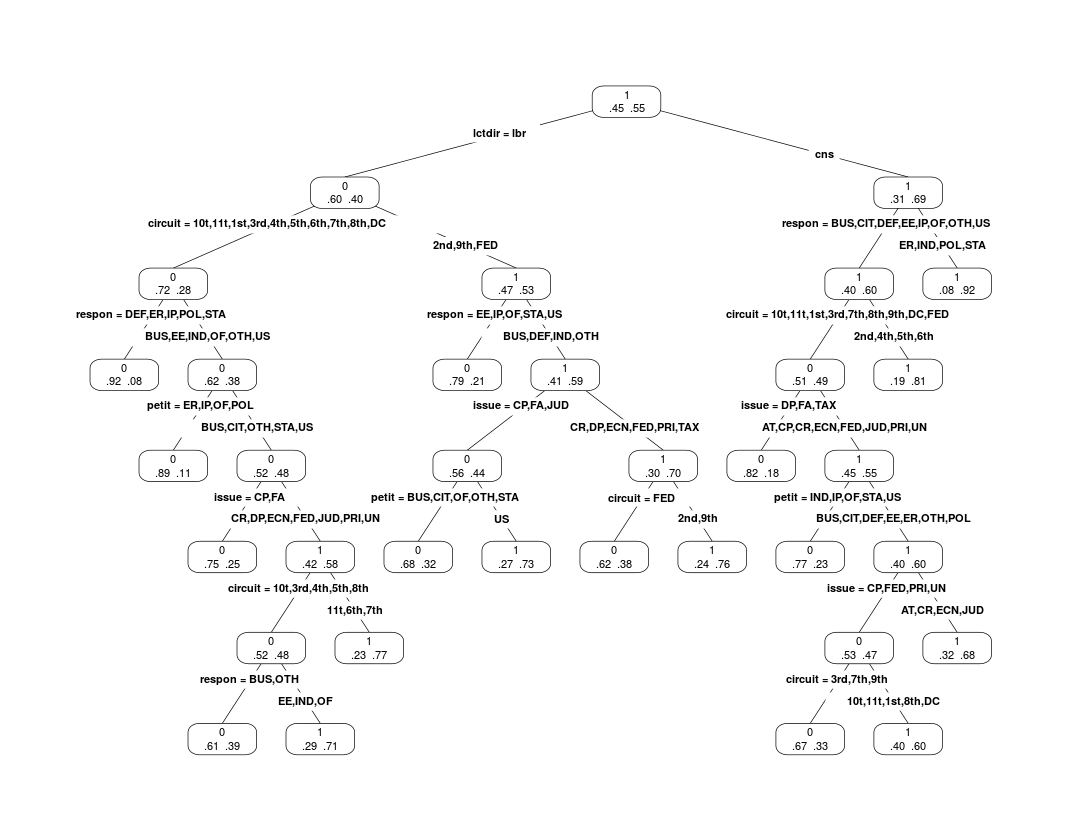

In [47]:
options(repr.plot.width=9, repr.plot.height=7) # resize IRkernel plot size
prp(cart1, extra=4, type=4, branch=0)
# ?prp
# summary(cart1)

In [52]:
?prp

To decide how we wish to split the nodes, we can use the following two indexes:

- **Gini index**: $\sum_{k=1}^{k}p_{mk}(1-p_{mk})$
- **Entropy**: $-\sum_{k=1}^{k}p_{mk}\:log(p_{mk})$
- **Classification error rate**: $1-max_k\:p_{mk}$

Choose predictor varible $x_i$ and threshold $t_j$ so as to minimise:

$$\large N_L\cdot Impurity(A_L) + N_R\cdot Impurity(A_R)$$

e.g. $15[1-(2/3)^2-(1/3)^2] + 10[1-()^2-()^2]$ (using Gini index metric)

In [56]:
predictcart1 <- predict(cart1, newdata=test, type="class")
table(predictcart1, test$rev)

            
predictcart1  0  1
           0 54 33
           1 28 69

Accuracy of CART is 0.6684, very close to the logistic regression.

In [58]:
table(train$rev) # baseline model


  0   1 
195 239 

In [61]:
printcp(cart1)


Classification tree:
rpart(formula = as.factor(rev) ~ petit + respon + circuit + unconst + 
    lctdir + issue, data = train)

Variables actually used in tree construction:
[1] circuit issue   lctdir  petit   respon 

Root node error: 195/434 = 0.44931

n= 434 

        CP nsplit rel error  xerror     xstd
1 0.210256      0   1.00000 1.00000 0.053142
2 0.035897      1   0.78974 0.78974 0.051116
3 0.023077      3   0.71795 0.85128 0.051921
4 0.018803      5   0.67179 0.88718 0.052307
5 0.012821      9   0.57949 0.86667 0.052094
6 0.010256     11   0.55385 0.87179 0.052149
7 0.010000     17   0.49231 0.86667 0.052094


Here, we can see that this tree has the lowest xstd error at tree depth 2.

$$\large min_{\:T\subseteq T_0}\:\:\:\:\sum_{m=1}^{|T|} \sum_{i\in R_m} (Y_i - \hat{Y}_{Rm})^2 + \alpha|T|$$

**Complexity parameter**: $0<\alpha<1$ (similar to regularisation function) $\alpha=0$ is the original full tree.

The lower the alpha, the greater the importance of the complexity of the model, which will do a great job in fitting training value ($MSE_{train}$ is low), but will end up with poor generality to test data. The higher the alpha, the more importance given to generalisability, giving $MSE_{train}$ low and high $MSE_{test}$

So how we select the optimal $\alpha$ to minimise xerror+xstd? For any value of $\alpha$, find the subtree $T\subseteq T_0$ of the original tree $T_0$ such that the above equation holds. This we will do by restricting the depth

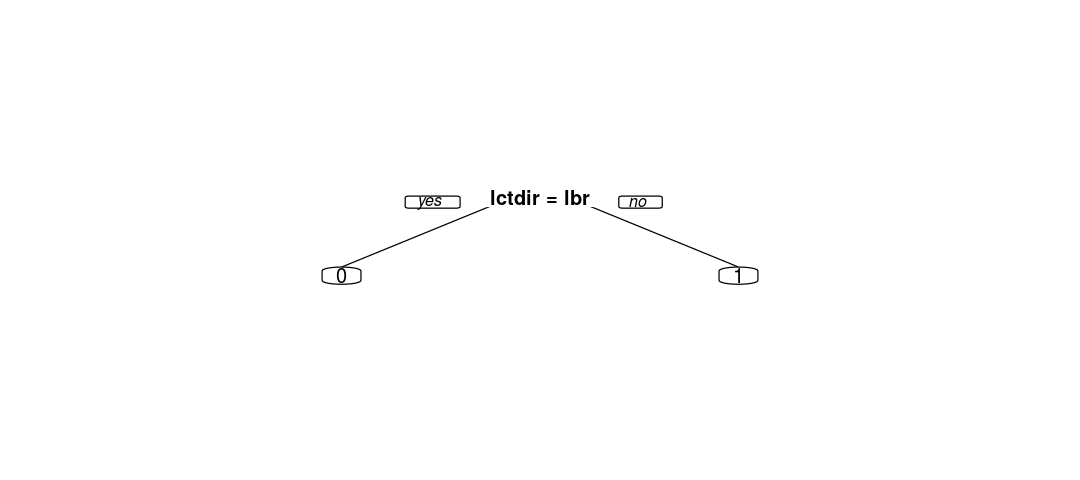

In [68]:
options(repr.plot.width=9, repr.plot.height=4) # resize IRkernel plot size
cart2 <- prune(cart1, cp=0.036)
prp(cart2)

In [67]:
predictcart2 <- predict(cart2, newdata=test, type="class")
table(test$rev, predictcart2)

   predictcart2
     0  1
  0 63 19
  1 34 68

### Random forests

Random forests rely upon bootstrapping upon smaller subsets of the original dataset (this may produce too similar trees with high correlations if only a few features are strong predictors), and also by having randomly chosen subsets of input variables for each tree.

In [72]:
library(randomForest)
set.seed(100)
forest <- randomForest(as.factor(rev)~petit+respon+circuit+unconst+lctdir+issue, data=train, nodesize=5, ntree=200)
predictforest <- predict(forest, newdata=test, type="class")

In [79]:
table(predictforest, test$rev)
# accuracy = 0.71 (we can see that adding more complexity may not necessarily be better than other models)

# original model
table(test$rev, predictcart2)
?printcp

             
predictforest  0  1
            0 45 20
            1 37 82

   predictcart2
     0  1
  0 63 19
  1 34 68

Boosting tree methods approximate the error terms instead, and builds new trees to minimise the error terms found inside. 